In [ ]:
# Corey: another classfier , maybe k folds and do the statistically analysis compare with others (if it doesn't take too long)
# I already ran keras 10 folds, so you don't need to re-run it
# Keras 10 folds value is :
# [0.88497216, 0.87198514, 0.88497216, 0.90909094, 0.89239335, 0.90538031, 0.89981449, 0.88868272, 0.89405203, 0.87360597

# Kivanc: classiers' TF,callback, ROC, cm ?  

In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from tensorflow.keras import backend
from keras import backend as K
import tensorflow as tf
import random
import collections
from keras.layers import Dropout
from keras.models import Sequential 
from keras.layers import Dense 
from pathlib import Path
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from six import StringIO
from copy import copy
from scipy import stats
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def encodeWithBLOSUM62(amino_acids):
    ## a function that returns the blosum62 vector given a certain aa 
    return list(BLOSUM62_MATRIX[amino_acids].values)

def blosumEncoding(data):
    ## a function that creates amino acid sequence that encode by blosum62 matrix 
    total_data_row =[]
    for each in data:
    
        eachrow =[]
        for aa in each:
            eachrow = eachrow+ encodeWithBLOSUM62(aa)
    
        total_data_row.append(eachrow)
    
    return pd.DataFrame(total_data_row)

def split(word): 
    return [char for char in word] 

COMMON_AMINO_ACIDS = collections.OrderedDict(sorted({
   "A": "Alanine",
   "R": "Arginine",
   "N": "Asparagine",
   "D": "Aspartic Acid",
   "C": "Cysteine",
   "E": "Glutamic Acid",
   "Q": "Glutamine",
   "G": "Glycine",
   "H": "Histidine",
   "I": "Isoleucine",
   "L": "Leucine",
   "K": "Lysine",
   "M": "Methionine",
   "F": "Phenylalanine",
   "P": "Proline",
   "S": "Serine",
   "T": "Threonine",
   "W": "Tryptophan",
   "Y": "Tyrosine",
   "V": "Valine",
   }.items()))
COMMON_AMINO_ACIDS_WITH_UNKNOWN = copy(COMMON_AMINO_ACIDS)
COMMON_AMINO_ACIDS_WITH_UNKNOWN["X"] = "Unknown"
   
AMINO_ACID_INDEX = dict((letter, i) for (i, letter) in enumerate(COMMON_AMINO_ACIDS_WITH_UNKNOWN))

AMINO_ACIDS = list(COMMON_AMINO_ACIDS_WITH_UNKNOWN.keys())
   
BLOSUM62_MATRIX = pd.read_csv(StringIO("""
  A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T  W  Y  V  X
   A  4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0  0
   R -1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3  0
   N -2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  0
   D -2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  0
   C  0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1  0
   Q -1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0
   E -1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  0
   G  0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3  0
   H -2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0
   I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3  0
   L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1  0
   K -1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0
   M -1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1  0
   F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  0 -3  0  6 -4 -2 -2  1  3 -1  0
   P -1 -2 -2 -1 -3 -1 -1 -2 -2 -3 -3 -1 -2 -4  7 -1 -1 -4 -3 -2  0
   S  1 -1  1  0 -1  0  0  0 -1 -2 -2  0 -1 -2 -1  4  1 -3 -2 -2  0
   T  0 -1  0 -1 -1 -1 -1 -2 -2 -1 -1 -1 -1 -2 -1  1  5 -2 -2  0  0 
   W -3 -3 -4 -4 -2 -2 -3 -2 -2 -3 -2 -3 -1  1 -4 -3 -2 11  2 -3  0
   Y -2 -2 -2 -3 -2 -1 -2 -3  2 -1 -1 -2 -1  3 -3 -2 -2  2  7 -1  0
   V  0 -3 -3 -3 -1 -2 -2 -3 -3  3  1 -2  1 -1 -2 -2  0 -3 -1  4  0
   X  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   """), sep='\s+').loc[AMINO_ACIDS, AMINO_ACIDS].astype("int8")
assert (BLOSUM62_MATRIX == BLOSUM62_MATRIX.T).all().all() 



ModuleNotFoundError: No module named 'keras'

In [ ]:
## Data preprocessing, importing the dataset
## need to change the file location
workdir = Path('/Volumes/Research/MAC_Research_Data/UGA/3Fall/DataMining6380/Mini_projecct_2/')
dataset = pd.read_csv(workdir/"HLA-A-01.txt",sep='\t')

peptides = dataset.peptide.values
final_peptide = [split(each_peptide) for each_peptide in peptides]

## encode y label
from sklearn import preprocessing
y = dataset.Binder.values
le = preprocessing.LabelEncoder()
a = le.fit(y)
y= le.transform(y)

## encode x label using bl62 matrix
X = blosumEncoding(final_peptide).values
## to see the dataset distribution 
#dataset.groupby('Binder').size()
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split 
val_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle= True,stratify = y)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=val_size, random_state = 0, shuffle=True)


Train on 5388 samples, validate on 599 samples
Epoch 1/200
5388/5388 [==============================] - 5s 956us/step - loss: 0.3821 - accuracy: 0.8315 - val_loss: 0.2961 - val_accuracy: 0.8798
Epoch 2/200
5388/5388 [==============================] - 1s 169us/step - loss: 0.3294 - accuracy: 0.8653 - val_loss: 0.3030 - val_accuracy: 0.8681
Epoch 3/200
5388/5388 [==============================] - 1s 180us/step - loss: 0.3220 - accuracy: 0.8682 - val_loss: 0.2849 - val_accuracy: 0.8781
Epoch 4/200
5388/5388 [==============================] - 1s 167us/step - loss: 0.3095 - accuracy: 0.8719 - val_loss: 0.2801 - val_accuracy: 0.8831
Epoch 5/200
5388/5388 [==============================] - 1s 151us/step - loss: 0.3007 - accuracy: 0.8708 - val_loss: 0.2720 - val_accuracy: 0.8898
Epoch 6/200
5388/5388 [==============================] - 1s 163us/step - loss: 0.2942 - accuracy: 0.8795 - val_loss: 0.2735 - val_accuracy: 0.8798
Epoch 7/200
5388/5388 [==============================] - 1s 151us/step 

5388/5388 [==============================] - 1s 255us/step - loss: 0.1737 - accuracy: 0.9341 - val_loss: 0.2961 - val_accuracy: 0.8881
Epoch 57/200
5388/5388 [==============================] - 2s 309us/step - loss: 0.1655 - accuracy: 0.9356 - val_loss: 0.2892 - val_accuracy: 0.8965
Epoch 58/200
5388/5388 [==============================] - 1s 222us/step - loss: 0.1527 - accuracy: 0.9421 - val_loss: 0.3151 - val_accuracy: 0.8932
Epoch 59/200
5388/5388 [==============================] - 2s 328us/step - loss: 0.1588 - accuracy: 0.9415 - val_loss: 0.2822 - val_accuracy: 0.8998
Epoch 60/200
5388/5388 [==============================] - 1s 155us/step - loss: 0.1643 - accuracy: 0.9371 - val_loss: 0.2734 - val_accuracy: 0.8965
Epoch 61/200
5388/5388 [==============================] - 1s 142us/step - loss: 0.1543 - accuracy: 0.9434 - val_loss: 0.2962 - val_accuracy: 0.8982
Epoch 62/200
5388/5388 [==============================] - 1s 157us/step - loss: 0.1567 - accuracy: 0.9423 - val_loss: 0.2969 

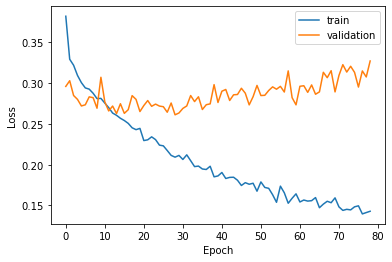

	True	False
True	543	101
Flase	75	778
--------------------
accuracy: 0.8824315297261189
	True	False
True	524	120
Flase	60	793
--------------------
accuracy: 0.8797595190380761
	True	False
True	483	161
Flase	42	811
--------------------
accuracy: 0.8643954575818303
0.8824315071105957


In [5]:
## Create an ANN model
# Training the model
# Dense object will take care to initialize the random number close to 0 ( first ANN step)
classifier = Sequential() # use the sequential layer
classifier.add(Dense(units = 80, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
classifier.add(Dropout(rate = 0.5))
classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
classifier.add(Dropout(rate = 0.5))
classifier.add(Dense(units = 80,   kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
## here is the output layer
## if we deal with more than 2 categories, the activation function needs to use softmax
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
opt = keras.optimizers.rmsprop(learning_rate= 0.001)
# Compiling the ANN
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience= 50)
# check the model performance and save the best model
mc = ModelCheckpoint('/Volumes/Research/MAC_Research_Data/UGA/3Fall/DataMining6380/Minproject2best_50batch_model.h5', monitor='val_loss', mode='min', save_best_only=True)
history = classifier.fit(X_train, y_train, validation_data= (X_val,y_val), batch_size = 50, epochs = 200, callbacks = [mc,es])

# the plot to see the lose function during the training process in training dataset and validation dataset

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
history.history['loss']

# Predicting the Test set results
y_pred = classifier.predict(X_test)


## the output give the probability and we apply the cut off to decide if the peptide is a binder or not
# Here I just want to know if we apply different cutoff, would it create different results?
thresheld = [0.5,0.7,0.9]
y_pred_list =[]
for i in thresheld:
    y_pred_value = (y_pred > i).tolist()
    y_pred_list.append(y_pred_value)
    
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
cm_list=[]
for i in range(len(y_pred_list)):
    cm = confusion_matrix(y_test, y_pred_list[i],labels=[1,0])
    cm_list.append(cm)
    print("","True","False",sep="\t")
    print("True",cm[0,0],cm[0,1],sep="\t" )
    print("Flase",cm[1,0],cm[1,1],sep="\t" )
    print('-'*20)
    print("accuracy:", metrics.accuracy_score(y_pred_list[i],y_test))   


test_loss, test_acc = classifier.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

In [10]:
## Stratified Kfold with Keras
## if your computer is not mac, the n_jobs = 1

def build_classifier():
    classifier = Sequential() # use the sequential layer
    ## init = kernel_initializer
    classifier.add(Dense(units = 80, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
    classifier.add(Dropout(p = 0.5))
    classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
    classifier.add(Dropout(p = 0.5))
    classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
    ## if we deal with more than 2 categories, the activation function needs to use softmax
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    opt = keras.optimizers.rmsprop(learning_rate= 0.001)
    # Compiling the ANN
    classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 50, epochs = 200)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = kfold, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()